In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re
import nltk
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#Read data
df = pd.read_csv('../input/fake-news/train.csv')

In [3]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df['title'][5]

'Jackie Mason: Hollywood Would Love Trump if He Bombed North Korea over Lack of Trans Bathrooms (Exclusive Video) - Breitbart'

In [5]:
df['text'][5]

'In these trying times, Jackie Mason is the Voice of Reason. [In this week’s exclusive clip for Breitbart News, Jackie discusses the looming threat of North Korea, and explains how President Donald Trump could win the support of the Hollywood left if the U. S. needs to strike first.  “If he decides to bomb them, the whole country will be behind him, because everybody will realize he had no choice and that was the only thing to do,” Jackie says. “Except the Hollywood left. They’ll get nauseous. ” “[Trump] could win the left over, they’ll fall in love with him in a minute. If he bombed them for a better reason,” Jackie explains. “Like if they have no transgender toilets. ” Jackie also says it’s no surprise that Hollywood celebrities didn’t support Trump’s strike on a Syrian airfield this month. “They were infuriated,” he says. “Because it might only save lives. That doesn’t mean anything to them. If it only saved the environment, or climate change! They’d be the happiest people in the wo

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


# Data Preprocessing

In [7]:
#Make one column by concatenating all 3 columns
df['total'] = df['title'] + ' '+df['author']+ ' '+df['text']

In [8]:
df =  df.drop(columns=['id' , 'title' , 'author' , 'text'] , axis = 1)

In [9]:
df

,label,total
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,1,Why the Truth Might Get You Fired Consortiumne...
3,1,15 Civilians Killed In Single US Airstrike Hav...
4,1,Iranian woman jailed for fictional unpublished...
...,...,...
20795,0,Rapper T.I.: Trump a ’Poster Child For White S...
20796,0,"N.F.L. Playoffs: Schedule, Matchups and Odds -..."
20797,0,Macy’s Is Said to Receive Takeover Approach by...
20798,1,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [10]:
#checking for Null Values
df.isnull().sum()

label       0
total    2515
dtype: int64

In [11]:
#Dropping the Null Values
df = df.dropna(axis = 0)

In [12]:
#Downloading the stopwords
ps = PorterStemmer()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
#Applying Preprocessing on text
def preprocessing(content):
    content = re.sub('[^a-zA-Z]' , ' ',content)
    content = content.lower()
    content = content.split()
    content = [ps.stem(word) for word in content if word not in stop_words]
    content = " ".join(content)
    return content

In [14]:
df['total'] = df['total'].apply(preprocessing)

In [15]:
#Checking after preprocessing
df['total']

0        hous dem aid even see comey letter jason chaff...
1        flynn hillari clinton big woman campu breitbar...
2        truth might get fire consortiumnew com truth m...
3        civilian kill singl us airstrik identifi jessi...
4        iranian woman jail fiction unpublish stori wom...
                               ...                        
20795    rapper trump poster child white supremaci jero...
20796    n f l playoff schedul matchup odd new york tim...
20797    maci said receiv takeov approach hudson bay ne...
20798    nato russia hold parallel exercis balkan alex ...
20799    keep f aliv david swanson david swanson author...
Name: total, Length: 18285, dtype: object

# Exploratory Data Analysis

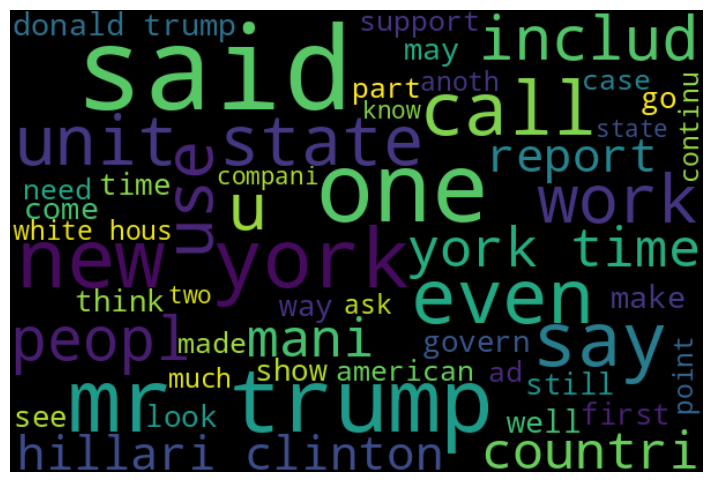

In [16]:
#Plotting wordcloud
all_words = " ".join([sentence for sentence in df['total']])

wordcloud = WordCloud(width = 600 , height = 400 , random_state = 42 , max_font_size = 100 , max_words = 50).generate(all_words)
plt.figure(figsize = (10,6))
plt.imshow(wordcloud , interpolation = 'bilinear')
plt.axis('off')
plt.show()

# Create Word Embeddings

In [17]:
#Creating Tokens and padding to make all the inputs of same length
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(df['total'])
sequences  = tokenizer.texts_to_sequences(df['total'])

padded_seq = pad_sequences(sequences , maxlen = 500 , padding='post' , truncating = 'post')

# Build and Train LSTM model

In [18]:
#Building the LSTM model
model = Sequential()

model.add(Embedding(input_dim =5000 , output_dim = 128 , input_shape = (500,)))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(64 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1 , activation = 'sigmoid'))

#Compiling Our model
model.compile(loss='binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 500, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 738,129 (2.82 MB)

 Trainable params: 738,129 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
#Dividing the data into train test split
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(padded_seq ,df['label'] ,test_size = 0.20 , random_state = 42 , stratify = df['label'])

In [20]:
#Strating the model training
history = model.fit(x_train , y_train , epochs = 25 , batch_size = 256 , validation_data = (x_test , y_test))

Epoch 1/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.5644 - loss: 0.6795 - val_accuracy: 0.5909 - val_loss: 0.6250
Epoch 2/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6019 - loss: 0.5993 - val_accuracy: 0.6120 - val_loss: 0.5835
Epoch 3/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6393 - loss: 0.5560 - val_accuracy: 0.6407 - val_loss: 0.5662
Epoch 4/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6339 - loss: 0.5450 - val_accuracy: 0.6054 - val_loss: 0.5714
Epoch 5/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6355 - loss: 0.5204 - val_accuracy: 0.6404 - val_loss: 0.5698
Epoch 6/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6491 - loss: 0.5099 - val_accuracy: 0.6393 - val_loss: 0.5749
Epoch 7/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6527 - loss: 0.5004 - val_accuracy: 0.6390 - val_loss: 0.5815
Epoch 8/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6634 - loss: 0.4961 - val_accuracy: 0.6410 - v

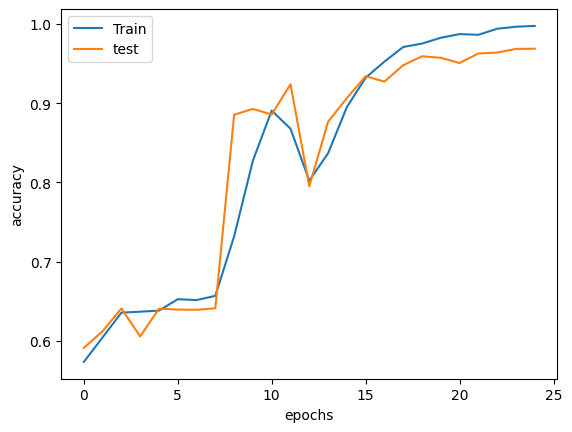

In [21]:
#Plotting the accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train' ,"test"])
plt.show()

In [22]:
from sklearn.metrics import accuracy_score , confusion_matrix

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

 Accuracy : 0.9688269073010665



Text(95.72222222222221, 0.5, 'True label')

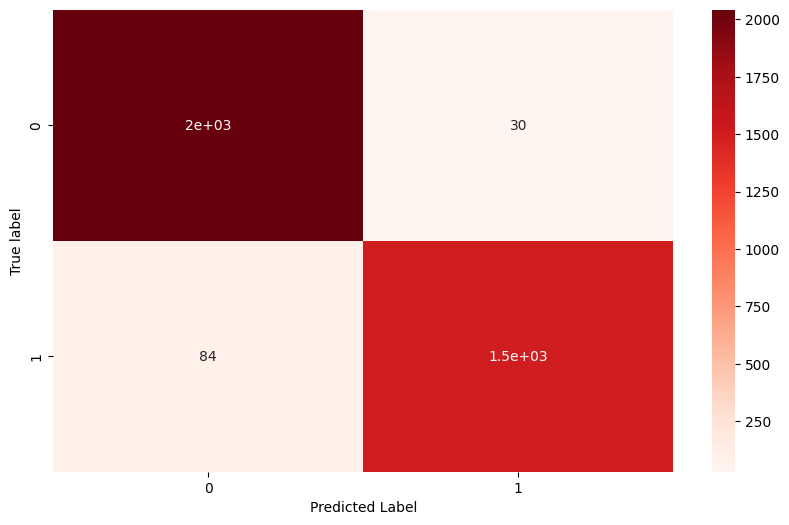

In [23]:
#if value > 0.5 then Real news else Fake
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(f"\n Accuracy : {accuracy_score(y_test , y_pred)}\n")

plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_test , y_pred) , annot = True , cmap ='Reds')
plt.xlabel("Predicted Label")
plt.ylabel('True label')

# Random Forest Classifier

In [24]:
#Creating Vectors
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['total'])

y = df['label']

X_train , X_test , y_train ,y_test = train_test_split(X , y , test_size = 0.2 ,random_state=42)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [26]:
#GridSearchCV for finding the best model parameters
clf = RandomForestClassifier(random_state= 42)

params = {
    "n_estimators" : [20,30],
    "max_depth": [100 , 200],
}

In [27]:
grid_search = GridSearchCV(estimator = clf , param_grid = params , cv = 5 , scoring = 'accuracy' , verbose = 1 ,n_jobs = -1 )
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [100, 200], 'n_estimators': [20, 30]},
             scoring='accuracy', verbose=1)

In [28]:
print(grid_search.best_params_)

{'max_depth': 200, 'n_estimators': 30}


In [29]:
#Getting the Best Model
best_model = grid_search.best_estimator_

In [30]:
accuracy = best_model.score(X_test , y_test)
print(accuracy)

0.89937106918239


In [31]:
import pickle

In [32]:
#Saving the model
pickle.dump(tokenizer , open('tokenizer.pkl' , 'wb'))
pickle.dump(model , open('model.pkl' , 'wb'))